In [ ]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import os
import io
import warnings
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Dropout, BatchNormalization,SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint
#warnings.filterwarnings('ignore')

In [ ]:
# Import dataset with Pandas 
URL="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv"
dataset = pd.read_csv(URL, encoding="ISO-8859-1")
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
dataset.describe(include="all")

print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

dataset.describe(include="all")

Number of rows : 5572

Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [ ]:
# Dropping useless columns
dataset= dataset.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis=1)

In [ ]:
# Let's have a look to the len of the dataset
len(dataset)

5572

In [ ]:
# We rename our columns for a better understanding
dataset.rename(columns = {'v1':'type', 'v2': 'mail'}, inplace = True)

In [ ]:
dataset.head()

,type,mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# check count and unique and top values and their frequency
dataset['type'].value_counts()

ham     4825
spam     747
Name: type, dtype: int64

In [ ]:
# target replaced by 1 or 0
dataset['type'] = dataset['type'].apply(lambda x:1 if x=='spam' else 0)

In [ ]:
!python -m spacy download en_core_web_md -q

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-02 08:53:23.171105: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-02 08:53:23.171278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-02 08:53:23.171303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [ ]:
# Import Spacy and french initialisation
import en_core_web_md
nlp = en_core_web_md.load()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
# Make text preprocessing to clean the column "mail" and create a new column "mail_clean"
dataset["mail_clean"] = dataset["mail"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
dataset["mail_clean"] = dataset["mail_clean"].apply(lambda x: x.replace("å","").lower().strip())
dataset["mail_clean"] = dataset["mail_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

dataset

,type,mail,mail_clean
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u u win 750 pound prize...
5568,0,Will Ì_ b going to esplanade fr home?,ì b esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestion
5570,0,The guy did some bitching but I acted like i'd...,guy bitching act like interested buy week free


In [ ]:
# We keep only the rows where mail clean malis not null 
mask = dataset["mail_clean"].isna()==False
dataset = dataset[mask]

In [ ]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer.fit_on_texts(dataset["mail_clean"]) # we apply our tokenizer to our column mail clean
dataset["mail_encoded"] = tokenizer.texts_to_sequences(dataset.mail_clean)
dataset["len_mail"] = dataset["mail_encoded"].apply(lambda x: len(x)) # we create a column len to display the len of our mail encoded
dataset = dataset[dataset["len_mail"]!=0] # we keep only not null values

In [ ]:
mails_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset.mail_encoded, padding="post") # padding of the sequences to be sure to same the same lenght

In [ ]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(mails_pad,dataset.type, test_size=0.3)

In [ ]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain)) 
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [ ]:
train_batch = train.shuffle(len(train)).batch(64) # we create our batches of 64 and we shuffle it
val_batch = val.shuffle(len(val)).batch(64)

In [ ]:
 # let's vizualise a batch
for review, star in train_batch.take(1):
  print(review, star)

tf.Tensor(
[[ 73   1 708 ...   0   0   0]
 [260  69   0 ...   0   0   0]
 [318 245 238 ...   0   0   0]
 ...
 [ 74 239   0 ...   0   0   0]
 [ 52  20 112 ...   0   0   0]
 [980  83 391 ...   0   0   0]], shape=(64, 54), dtype=int32) tf.Tensor(
[0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0], shape=(64,), dtype=int64)


##Simple RNN

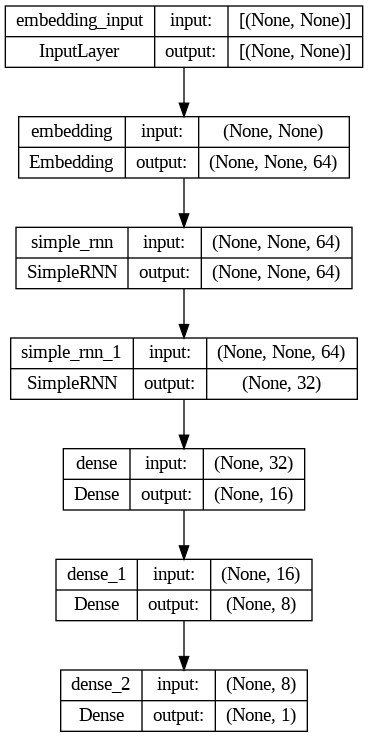

In [ ]:
vocab_size = len(tokenizer.word_index) # We define our vocab size
model_RNN = tf.keras.Sequential([      
                  Embedding(vocab_size, 64,name="embedding"),# Word Embedding layer  
                  SimpleRNN(units=64, return_sequences=True), 
                  SimpleRNN(units=32, return_sequences=False), 
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid")
])
tf.keras.utils.plot_model(model_RNN, show_shapes=True)

In [ ]:
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          522880    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 534,913
Trainable params: 534,913
Non-trai

In [ ]:
optimizer= tf.keras.optimizers.Adam()

model_RNN.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=[tf.metrics.BinaryAccuracy()])
        

In [ ]:
#We intriduce the parameter class_weight because of our umbalanced dataset 
weights = 1/(dataset["type"]).value_counts()
weights = weights * len(dataset)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.5801419965576592, 1: 3.619463087248322}

In [ ]:
# Model training 
history = model_RNN.fit(train_batch ,
                    epochs=50, 
                    validation_data=val_batch ,
                    class_weight=weights)

Epoch 1/50
59/59 [==============================] - 5s 56ms/step - loss: 0.0268 - binary_accuracy: 0.9883 - val_loss: 0.2770 - val_binary_accuracy: 0.9295
Epoch 2/50
59/59 [==============================] - 3s 48ms/step - loss: 0.0143 - binary_accuracy: 0.9928 - val_loss: 0.2930 - val_binary_accuracy: 0.9357
Epoch 3/50
59/59 [==============================] - 3s 54ms/step - loss: 0.0219 - binary_accuracy: 0.9966 - val_loss: 0.2999 - val_binary_accuracy: 0.9345
Epoch 4/50
59/59 [==============================] - 3s 53ms/step - loss: 0.0150 - binary_accuracy: 0.9960 - val_loss: 0.3194 - val_binary_accuracy: 0.9302
Epoch 5/50
59/59 [==============================] - 4s 66ms/step - loss: 0.0226 - binary_accuracy: 0.9966 - val_loss: 0.3012 - val_binary_accuracy: 0.9295
Epoch 6/50
59/59 [==============================] - 3s 47ms/step - loss: 0.0100 - binary_accuracy: 0.9974 - val_loss: 0.3160 - val_binary_accuracy: 0.9295
Epoch 7/50
59/59 [==============================] - 4s 61ms/step - los

In [ ]:
model_RNN.save("model_simpleRNN.h5") # We save our model
json.dump(model_RNN.history.history, open("/content/simpleRNN_history.json", 'w')) # We save the results during epochs


In [ ]:
# We get from the saved file the history info in order to vizualise the loss and accuracy during epochs
tf.keras.utils.get_file("/content/model_simpleRNN.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model_lstm_reg.h5")
tf.keras.utils.get_file("/content/simpleRNN_history.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model_simpleRNN.json")
SimpleRNN_history = json.load(open("/content/simpleRNN_history.json", 'r'))
model_RNN = tf.keras.models.load_model("/content/model_simpleRNN.h5")

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=SimpleRNN_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=SimpleRNN_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=SimpleRNN_history["binary_accuracy"],
                    mode='lines',
                    name='accuracy'))
fig.add_trace(go.Scatter(y=SimpleRNN_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_accuracy'))
fig.show()

It doesn't provide good results, simple RNN is not really effcient with long sequences

## LSTM

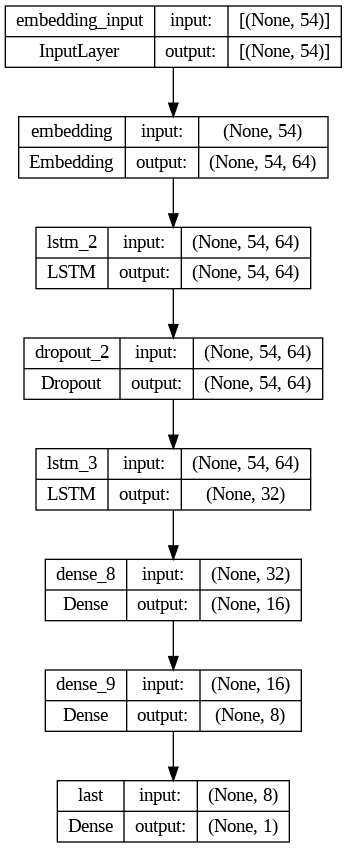

In [ ]:
vocab_size = len(tokenizer.word_index) #definition of our vocab size
model_lstm = tf.keras.Sequential([ #creation of our lstm model
                  Embedding(vocab_size+1, 64, input_shape=[review.shape[1],],name="embedding"),
                  LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  Dropout(0.2),
                  LSTM(units=32, return_sequences=False), # returns the last output
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid", name="last")
])
tf.keras.utils.plot_model(model_lstm, show_shapes=True)

In [ ]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 64)            522944    
                                                                 
 lstm_2 (LSTM)               (None, 54, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 54, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                                 
 last (Dense)                (None, 1)                

In [ ]:
optimizer= tf.keras.optimizers.Adam()

model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.BinaryAccuracy()])

In [ ]:
model_lstm.fit(train_batch,
              epochs=50, 
              validation_data=val_batch,
               class_weight=weights)

Epoch 1/50
59/59 [==============================] - 14s 132ms/step - loss: 0.6833 - binary_accuracy: 0.4450 - val_loss: 0.6905 - val_binary_accuracy: 0.8504
Epoch 2/50
59/59 [==============================] - 6s 105ms/step - loss: 0.6828 - binary_accuracy: 0.8668 - val_loss: 0.6889 - val_binary_accuracy: 0.8504
Epoch 3/50
59/59 [==============================] - 8s 136ms/step - loss: 0.6827 - binary_accuracy: 0.8668 - val_loss: 0.6874 - val_binary_accuracy: 0.8504
Epoch 4/50
59/59 [==============================] - 7s 117ms/step - loss: 0.6827 - binary_accuracy: 0.8668 - val_loss: 0.6854 - val_binary_accuracy: 0.8504
Epoch 5/50
59/59 [==============================] - 8s 129ms/step - loss: 0.6827 - binary_accuracy: 0.8668 - val_loss: 0.6858 - val_binary_accuracy: 0.8504
Epoch 6/50
59/59 [==============================] - 8s 135ms/step - loss: 0.6827 - binary_accuracy: 0.8668 - val_loss: 0.6834 - val_binary_accuracy: 0.8504
Epoch 7/50
59/59 [==============================] - 8s 135ms/st

In [ ]:
# We get from the saved file the history info in order to vizualise the loss and accuracy during epochs
tf.keras.utils.get_file("/content/model_lstm.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model_lstm.h5")
tf.keras.utils.get_file("/content/LSTM_history.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/LSTM_history.json")
LSTM_history = json.load(open("/content/LSTM_history.json", 'r'))
model_lstm = tf.keras.models.load_model("/content/model_lstm.h5")

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=LSTM_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=LSTM_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()


LSTM does'nt give good results let's try GRU

## GRU

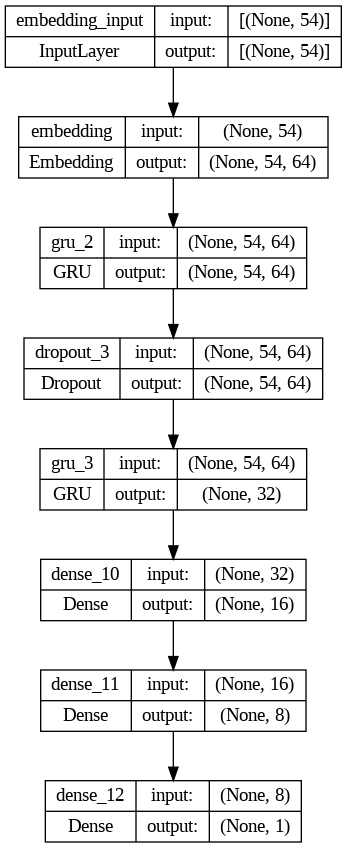

In [ ]:
#We try GRU model
vocab_size = len(tokenizer.word_index)
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[review.shape[1],],name="embedding"),
                  GRU(units=64, return_sequences=True), # maintains the sequential nature
                  Dropout(0.2),
                  GRU(units=32, return_sequences=False), # returns the last output
                  #Dropout(0.15),
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid")
])
tf.keras.utils.plot_model(model_gru, show_shapes=True)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( # We try a learning rate schedule to try to improve the learning rate using exponential decay calculation
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.4,
    staircase=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
#optimizer= tf.keras.optimizers.Adam()
model_gru.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.BinaryAccuracy()])

In [ ]:
model_gru.fit(train_batch,
              epochs=50, 
              validation_data=val_batch,class_weight=weights)

Epoch 1/50
59/59 [==============================] - 14s 125ms/step - loss: 0.6828 - binary_accuracy: 0.8156 - val_loss: 0.6903 - val_binary_accuracy: 0.8504
Epoch 2/50
59/59 [==============================] - 7s 118ms/step - loss: 0.6827 - binary_accuracy: 0.8095 - val_loss: 0.6888 - val_binary_accuracy: 0.8504
Epoch 3/50
59/59 [==============================] - 6s 98ms/step - loss: 0.6827 - binary_accuracy: 0.8641 - val_loss: 0.6879 - val_binary_accuracy: 0.8504
Epoch 4/50
59/59 [==============================] - 6s 100ms/step - loss: 0.6828 - binary_accuracy: 0.8652 - val_loss: 0.6867 - val_binary_accuracy: 0.8504
Epoch 5/50
59/59 [==============================] - 6s 100ms/step - loss: 0.6826 - binary_accuracy: 0.8668 - val_loss: 0.6861 - val_binary_accuracy: 0.8504
Epoch 6/50
59/59 [==============================] - 6s 101ms/step - loss: 0.6827 - binary_accuracy: 0.8668 - val_loss: 0.6855 - val_binary_accuracy: 0.8504
Epoch 7/50
59/59 [==============================] - 8s 139ms/ste

In [ ]:
model_gru.save("model_gru.h5")
json.dump(model_gru.history.history, open("/content/GRU_history.json", 'w'))

In [ ]:
tf.keras.utils.get_file("/content/model_gru.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model_gru.h5")
tf.keras.utils.get_file("/content/GRU_history.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/GRU_history.json")
GRU_history = json.load(open("/content/GRU_history.json", 'r'))
model_gru = tf.keras.models.load_model("/content/model_gru.h5")

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=GRU_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=GRU_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=GRU_history["binary_accuracy"],
                    mode='lines',
                    name='accuracy'))
fig.add_trace(go.Scatter(y=GRU_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_accuracy'))
fig.show()

# Model creation with embedding layers

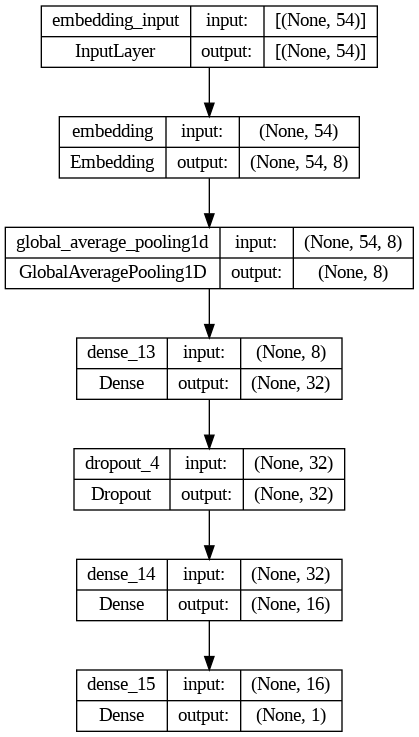

In [ ]:
vocab_size = len(tokenizer.word_index)
model = tf.keras.Sequential([             
            tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),  
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.Dense(16, activation='relu'),      
            tf.keras.layers.Dense(1, activation="sigmoid")
                ])

tf.keras.utils.plot_model(model, show_shapes=True)



In [ ]:

optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])



In [ ]:
# visualization of the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 8)             65368     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_13 (Dense)            (None, 32)                288       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                      

In [ ]:
# train model
model.fit(train_batch, 
            epochs=50, 
            validation_data=val_batch,
            class_weight=weights)

Epoch 1/50
59/59 [==============================] - 3s 8ms/step - loss: 0.6780 - binary_accuracy: 0.8665 - val_loss: 0.6438 - val_binary_accuracy: 0.8504
Epoch 2/50
59/59 [==============================] - 0s 5ms/step - loss: 0.6501 - binary_accuracy: 0.8977 - val_loss: 0.5723 - val_binary_accuracy: 0.9203
Epoch 3/50
59/59 [==============================] - 0s 5ms/step - loss: 0.5416 - binary_accuracy: 0.9576 - val_loss: 0.3731 - val_binary_accuracy: 0.9549
Epoch 4/50
59/59 [==============================] - 0s 5ms/step - loss: 0.3482 - binary_accuracy: 0.9759 - val_loss: 0.2305 - val_binary_accuracy: 0.9679
Epoch 5/50
59/59 [==============================] - 0s 6ms/step - loss: 0.2063 - binary_accuracy: 0.9793 - val_loss: 0.1304 - val_binary_accuracy: 0.9703
Epoch 6/50
59/59 [==============================] - 1s 9ms/step - loss: 0.1438 - binary_accuracy: 0.9809 - val_loss: 0.1033 - val_binary_accuracy: 0.9740
Epoch 7/50
59/59 [==============================] - 0s 7ms/step - loss: 0.10

In [ ]:
model_gru.save("model.h5")
json.dump(model.history.history, open("/content/model_history.json", 'w'))

In [ ]:
tf.keras.utils.get_file("/content/model.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model.h5")
tf.keras.utils.get_file("/content/model_history.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/models/M08_Deep_learning/Text_classification/model_history.json")
model_history = json.load(open("/content/model_history.json", 'r'))
model = tf.keras.models.load_model("/content/model.h5")

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=model_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=model_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=model_history["binary_accuracy"],
                    mode='lines',
                    name='accuracy'))
fig.add_trace(go.Scatter(y=model_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_accuracy'))
fig.show()

## Conclusion
Our last model performs better than the Simple RNN, GRU or LSTM.
It can be interesting to test BERT model using transfer learning to compare the results
We can also improve our model to handel the unbalanced dataset and to fight the overfitting